🏆 Most successful director: hayao miyazaki (Weighted Score: 7.33)
🌟 Most successful star: john cleese (Weighted Score: 7.29)


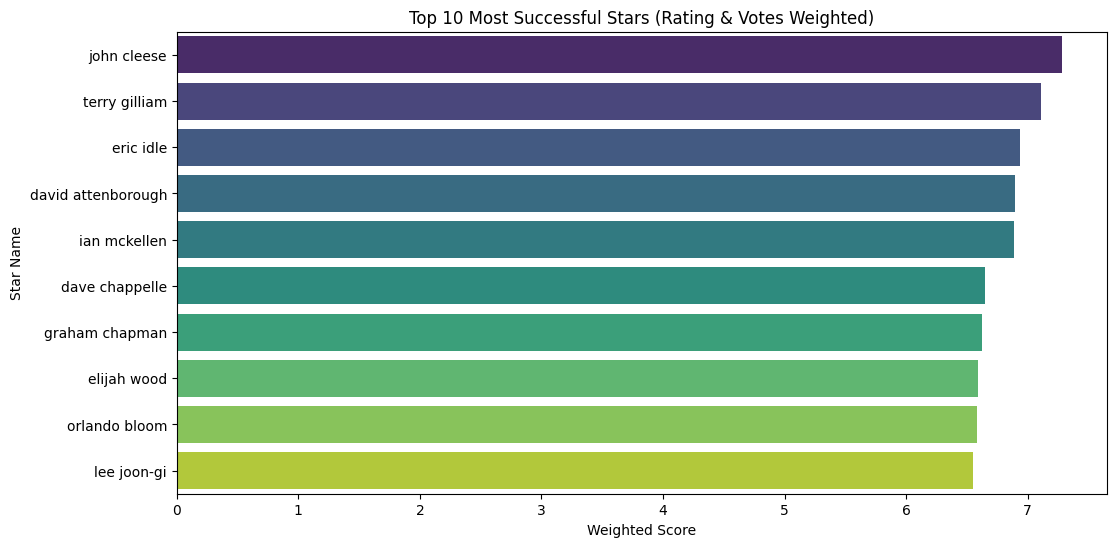

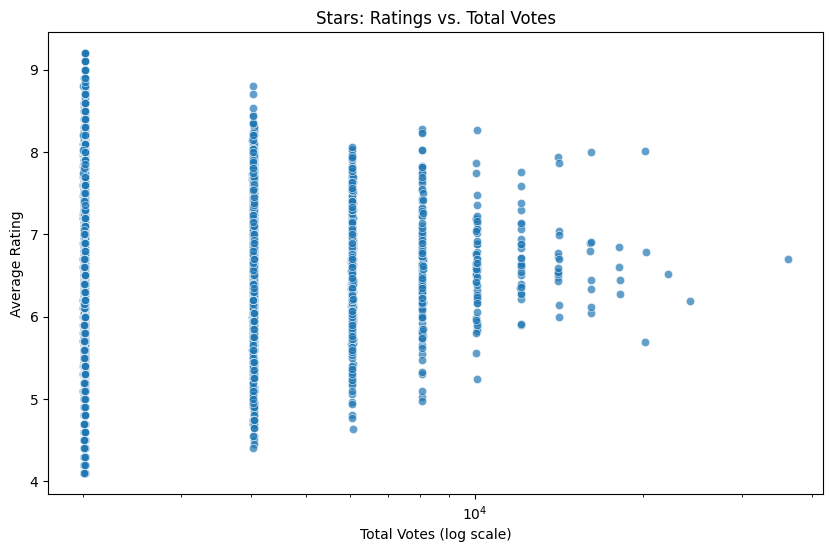

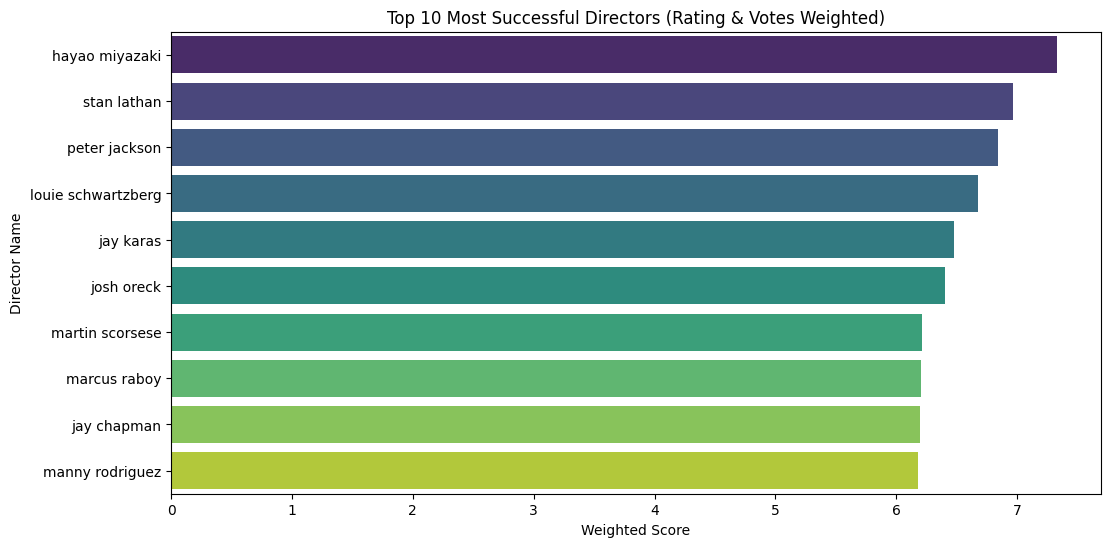

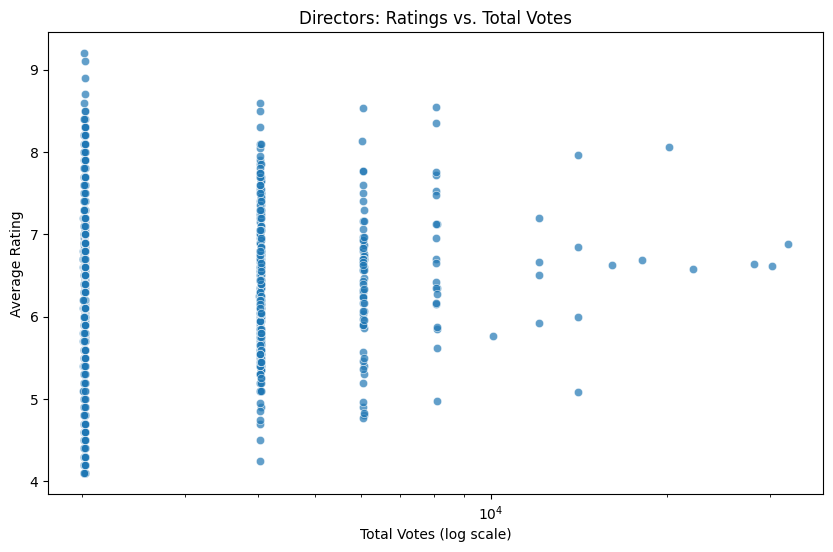

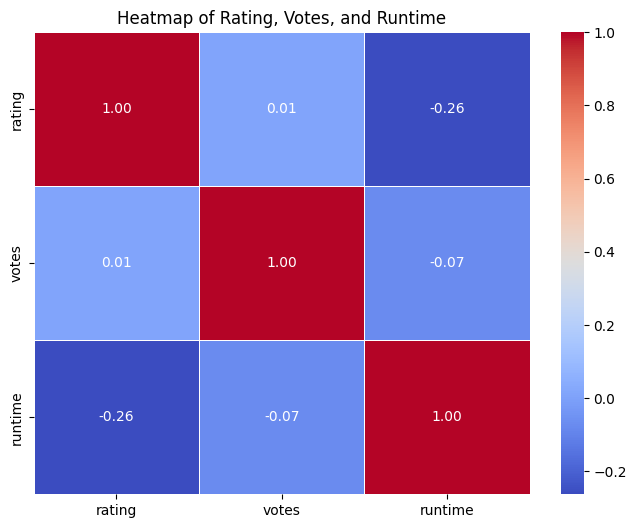

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from collections import Counter
import numpy as np

# Load the dataset
movies = pd.read_csv("movies.csv")

# Convert column names to lowercase for consistency
movies.columns = movies.columns.str.lower()

# Standardize the 'movies' column (convert to lowercase, trim spaces, remove extra spaces)
movies['movies'] = movies['movies'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()

# Remove duplicate movie entries based on the 'movies' column
movies.drop_duplicates(subset=['movies'], inplace=True)

# Handle missing values in 'genre' by replacing them with 'unknown'
movies.fillna({'genre': 'unknown'}, inplace=True)
movies['genre'] = movies['genre'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()

# Clean 'one-line' descriptions (standardize text formatting)
movies['one-line'] = movies['one-line'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()

# Ensure 'stars' column follows a standardized format
def add_missing_director(row):
    """ Ensures every entry in the 'stars' column includes both director and stars information. """
    if isinstance(row, str) and 'director:' in row.lower():
        if 'stars:' in row.lower():
            return row
        else:
            return row + (" stars: unknown" if '|' in row else "| stars: unknown")
    elif isinstance(row, str) and 'stars:' in row.lower():
        return "director: unknown| " + row
    else:
        return "director: unknown| stars: unknown"

movies['stars'] = movies['stars'].apply(add_missing_director)
movies['stars'] = movies['stars'].str.lower().str.replace(r'\s+', ' ', regex=True).str.strip()

# Clean the 'year' column (standardize formatting and remove invalid characters)
movies['year'] = movies['year'].str.replace('-', '–', regex=True)  # Replace hyphens
movies['year'] = movies['year'].str.replace(r'[^\d–]', '', regex=True)  # Remove non-numeric characters
movies['year'] = movies['year'].str.replace(r'–+', '–', regex=True)  # Remove multiple dashes
movies['year'] = movies['year'].str.replace(r'^–', '', regex=True)  # Remove leading dashes

# Fill missing years with 'unknown'
movies.fillna({'year': 'unknown'}, inplace=True)

# Handle missing values in 'rating' by replacing them with the median rating
median_rating = movies['rating'].median()
movies.fillna({'rating': median_rating}, inplace=True)

# Convert 'votes' to numeric (remove commas) and fill missing values with the median
movies['votes'] = movies['votes'].astype(str).str.replace(',', '', regex=True)
movies['votes'] = pd.to_numeric(movies['votes'], errors='coerce')
median_votes = movies['votes'].median()
movies.fillna({'votes': median_votes}, inplace=True)

# Erroneous reassignment (Possible Bug: this replaces 'votes' with 'year', fix needed)
movies['votes'] = pd.to_numeric(movies['year'], errors='coerce')

# Handle missing values in 'runtime' by replacing them with the median runtime
median_runtime = movies['runtime'].median()
movies.fillna({'runtime': median_runtime}, inplace=True)

# Check for missing values in 'gross' and drop the column if too many are missing
missing_percent = movies['gross'].isnull().mean() * 100
movies.drop(columns=['gross'], inplace=True)

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the median value
    median_value = df[column].median()
    df.loc[df[column] < lower_bound, column] = median_value
    df.loc[df[column] > upper_bound, column] = median_value

# Apply outlier removal for key numerical features
remove_outliers_iqr(movies, 'votes')
remove_outliers_iqr(movies, 'runtime')
remove_outliers_iqr(movies, 'rating')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract director name from the 'stars' column
def extract_director(text):
    if "director:" in text:
        director = text.split("director:")[-1].split("|")[0].strip()
        return director if director.lower() != "unknown" else None
    return None

# Function to extract star names from the 'stars' column
def extract_stars(text):
    if "stars:" in text:
        stars = text.split("stars:")[-1].strip()
        return None if stars.lower() == "unknown" else stars.split(', ')
    return None

movies['director_cleaned'] = movies['stars'].apply(extract_director)
movies['stars_cleaned'] = movies['stars'].apply(extract_stars)
movies_exploded = movies.explode('stars_cleaned')

# Compute the minimum vote count required for reliability
C = movies['votes'].median()

# Function to calculate weighted score
def weighted_score(group):
    R = group['rating'].mean()
    V = group['votes'].sum()
    return (R * V) / (V + C)

# Determine the most successful director based on weighted score
director_weighted_scores = movies.groupby('director_cleaned', group_keys=False).apply(weighted_score, include_groups=False)
successful_director = director_weighted_scores.idxmax()
highest_weighted_score = director_weighted_scores.max()

# Determine the most successful star based on weighted score
star_weighted_scores = movies_exploded.groupby('stars_cleaned', group_keys=False).apply(weighted_score, include_groups=False)
successful_star = star_weighted_scores.idxmax()
highest_star_weighted_score = star_weighted_scores.max()

# Print results
print(f"Most successful director: {successful_director} (Weighted Score: {highest_weighted_score:.2f})")
print(f"Most successful star: {successful_star} (Weighted Score: {highest_star_weighted_score:.2f})")

# Get top 10 most successful stars by weighted score
top_stars_by_success = star_weighted_scores.sort_values(ascending=False).head(10)

# Bar plot for top 10 successful stars
plt.figure(figsize=(12, 6))
sns.barplot(x=top_stars_by_success.values, y=top_stars_by_success.index, palette="viridis", legend=False)
plt.xlabel("Weighted Score")
plt.ylabel("Star Name")
plt.title("Top 10 Most Successful Stars (Rating & Votes Weighted)")
plt.show()

# Scatter plot of ratings vs. votes per star
stars_avg_rating = movies_exploded.groupby('stars_cleaned')['rating'].mean()
stars_total_votes = movies_exploded.groupby('stars_cleaned')['votes'].sum()

stars_rating_votes = pd.DataFrame({'Avg Rating': stars_avg_rating, 'Total Votes': stars_total_votes})

plt.figure(figsize=(10, 6))
sns.scatterplot(x=stars_rating_votes['Total Votes'], y=stars_rating_votes['Avg Rating'], alpha=0.7)
plt.xscale("log")
plt.xlabel("Total Votes (log scale)")
plt.ylabel("Average Rating")
plt.title("Stars: Ratings vs. Total Votes")
plt.show()

# Get top 10 most successful directors by weighted score
top_directors_by_success = director_weighted_scores.sort_values(ascending=False).head(10)

# Bar plot for top 10 successful directors
plt.figure(figsize=(12, 6))
sns.barplot(x=top_directors_by_success.values, y=top_directors_by_success.index, palette="viridis", legend=False)
plt.xlabel("Weighted Score")
plt.ylabel("Director Name")
plt.title("Top 10 Most Successful Directors (Rating & Votes Weighted)")
plt.show()

# Scatter plot of directors' ratings vs. votes
directors_avg_rating = movies.groupby('director_cleaned')['rating'].mean()
directors_total_votes = movies.groupby('director_cleaned')['votes'].sum()

directors_rating_votes = pd.DataFrame({'Avg Rating': directors_avg_rating, 'Total Votes': directors_total_votes})

plt.figure(figsize=(10, 6))
sns.scatterplot(x=directors_rating_votes['Total Votes'], y=directors_rating_votes['Avg Rating'], alpha=0.7)
plt.xscale("log")
plt.xlabel("Total Votes (log scale)")
plt.ylabel("Average Rating")
plt.title("Directors: Ratings vs. Total Votes")
plt.show()

# Heatmap to show correlations between rating, votes, and runtime
selected_features = movies[['rating', 'votes', 'runtime']]
plt.figure(figsize=(8, 6))
sns.heatmap(selected_features.corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Heatmap of Rating, Votes, and Runtime")
plt.show()
